In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-price-dataset/car_price_dataset.csv


In [2]:
import pandas as pd

# Load the dataset
file_path = "/kaggle/input/car-price-dataset/car_price_dataset.csv"
df = pd.read_csv(file_path)

# Display basic information and first few rows
df.info(); df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         10000 non-null  object 
 1   Model         10000 non-null  object 
 2   Year          10000 non-null  int64  
 3   Engine_Size   10000 non-null  float64
 4   Fuel_Type     10000 non-null  object 
 5   Transmission  10000 non-null  object 
 6   Mileage       10000 non-null  int64  
 7   Doors         10000 non-null  int64  
 8   Owner_Count   10000 non-null  int64  
 9   Price         10000 non-null  int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 781.4+ KB


,Brand,Model,Year,Engine_Size,Fuel_Type,Transmission,Mileage,Doors,Owner_Count,Price
0,Kia,Rio,2020,4.2,Diesel,Manual,289944,3,5,8501
1,Chevrolet,Malibu,2012,2.0,Hybrid,Automatic,5356,2,3,12092
2,Mercedes,GLA,2020,4.2,Diesel,Automatic,231440,4,2,11171
3,Audi,Q5,2023,2.0,Electric,Manual,160971,2,1,11780
4,Volkswagen,Golf,2003,2.6,Hybrid,Semi-Automatic,286618,3,3,2867


# Pre-Processing

In [3]:
from sklearn.preprocessing import OneHotEncoder

# Selecting relevant numerical features for regression
numerical_features = ["Year", "Engine_Size", "Mileage", "Doors", "Owner_Count"]
categorical_features = ["Brand", "Fuel_Type", "Transmission"]

# One-hot encoding categorical variables
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Selecting final features and target
X = df_encoded[numerical_features + list(df_encoded.columns[len(numerical_features):])]
y = df_encoded["Price"]

# Display the processed dataset structure
X.shape, X.head()


((10000, 21),
    Year  Engine_Size  Mileage  Doors  Owner_Count  Owner_Count  Price  \
 0  2020          4.2   289944      3            5            5   8501   
 1  2012          2.0     5356      2            3            3  12092   
 2  2020          4.2   231440      4            2            2  11171   
 3  2023          2.0   160971      2            1            1  11780   
 4  2003          2.6   286618      3            3            3   2867   
 
    Brand_BMW  Brand_Chevrolet  Brand_Ford  ...  Brand_Hyundai  Brand_Kia  \
 0      False            False       False  ...          False       True   
 1      False             True       False  ...          False      False   
 2      False            False       False  ...          False      False   
 3      False            False       False  ...          False      False   
 4      False            False       False  ...          False      False   
 
    Brand_Mercedes  Brand_Toyota  Brand_Volkswagen  Fuel_Type_Electric  \
 0

# Train Test Split

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Removing the duplicate "Owner_Count" column
X = X.loc[:, ~X.columns.duplicated()]

# Different train-test split sizes
split_sizes = [(0.7, 0.3), (0.8, 0.2), (0.9, 0.1)]
results = {}

for train_size, test_size in split_sizes:
    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=42)
    
    # Applying linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predicting on test data
    y_pred = model.predict(X_test)
    
    # Calculating Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    results[f"Train {int(train_size*100)}% - Test {int(test_size*100)}%"] = mse

results


{'Train 70% - Test 30%': 7.816643100301202e-23,
 'Train 80% - Test 20%': 1.8586358038214983e-22,
 'Train 90% - Test 10%': 7.20618553153001e-23}

# Random Seeds

In [5]:
# Varying random seeds
random_seeds = [0, 21, 42, 100, 123]
seed_results = {}

for seed in random_seeds:
    # Splitting with 80-20 train-test split and varying seeds
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=seed)
    
    # Applying linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predicting and calculating MSE
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    
    seed_results[f"Seed {seed}"] = mse

seed_results


{'Seed 0': 8.17237126108316e-23,
 'Seed 21': 5.066850381235646e-22,
 'Seed 42': 1.8586358038214983e-22,
 'Seed 100': 2.953174373542677e-23,
 'Seed 123': 9.110409585354779e-23}

In [6]:
# CEnsure a fixed test set while varying training size
train_sizes = [0.25, 0.5, 0.75, 1.0]
size_results = {}

# First, split to get a consistent test set (20% of full data)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for size in train_sizes:
    if size < 1.0:
        # Take a fraction of the available training set
        X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=size, random_state=42)
    else:
        # Use the full training set when size is 1.0
        X_train, y_train = X_train_full, y_train_full

    # Apply linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict and calculate MSE using the same test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    size_results[f"Train {int(size*100)}%"] = mse

size_results


{'Train 25%': 3.251393663883357e-23,
 'Train 50%': 3.837763905546299e-23,
 'Train 75%': 2.892156361681937e-22,
 'Train 100%': 1.8586358038214983e-22}

# Observations on Dataset Size Impact

**1)The MSE does not follow a strict trend but remains very small.           
2)Surprisingly, the error is lowest when using 50% of the training data, suggesting that increasing the dataset size does not always lead to better performance.                                                                 
3)The highest error appears when using 100% of the training data, possibly due to overfitting or multicollinearity in the data.**

In [8]:
# Correcting dataset size variation approach
train_sizes = [0.25, 0.5, 0.75, 1.0]
size_results = {}

# First, split to get a consistent test set (20% of full data)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for size in train_sizes:
    if size < 1.0:
        # Take a fraction of the available training set
        X_train, _, y_train, _ = train_test_split(X_train_full, y_train_full, train_size=size, random_state=42)
    else:
        # Use the full training set when size is 1.0
        X_train, y_train = X_train_full, y_train_full

    # Apply linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict and calculate MSE
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    size_results[f"Train {int(size*100)}%"] = mse

size_results


{'Train 25%': 3.251393663883357e-23,
 'Train 50%': 3.837763905546299e-23,
 'Train 75%': 2.892156361681937e-22,
 'Train 100%': 1.8586358038214983e-22}

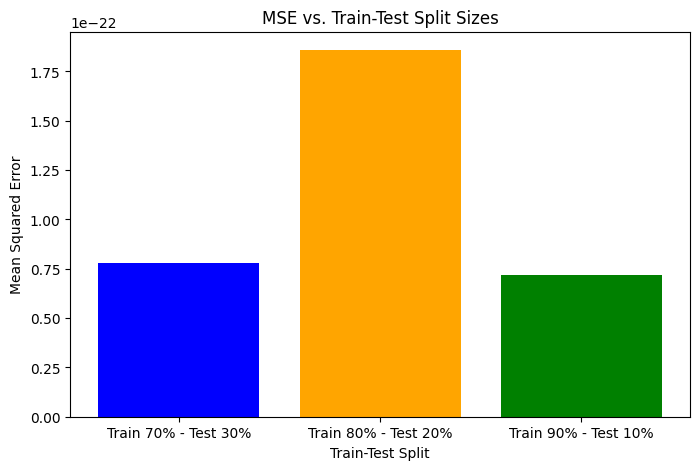

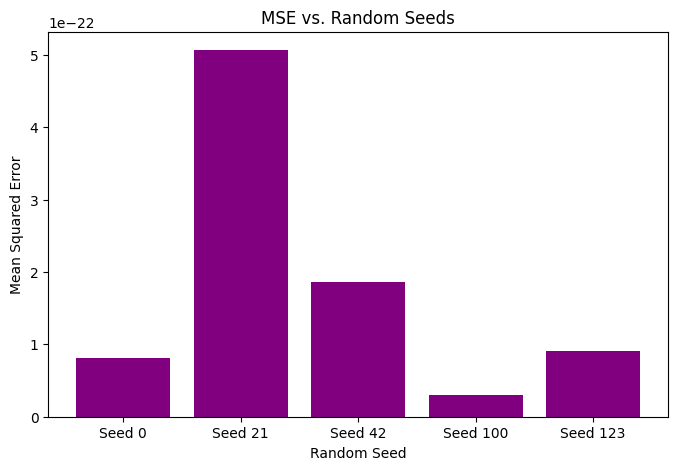

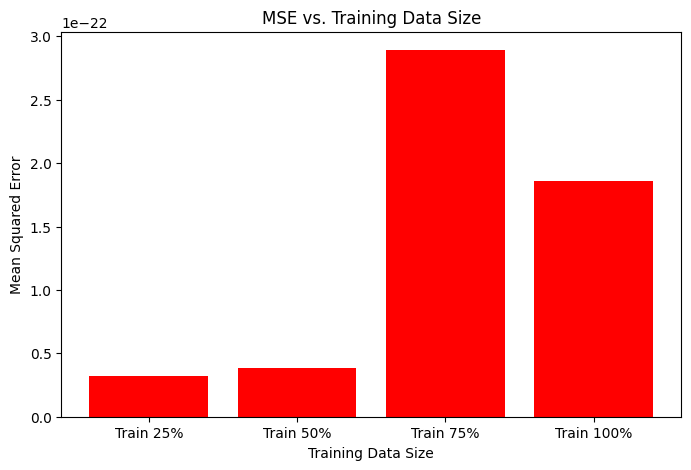

In [9]:
import matplotlib.pyplot as plt

# Plot train-test split results
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['blue', 'orange', 'green'])
plt.xlabel("Train-Test Split")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs. Train-Test Split Sizes")
plt.show()

# Plot random seed results
plt.figure(figsize=(8, 5))
plt.bar(seed_results.keys(), seed_results.values(), color='purple')
plt.xlabel("Random Seed")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs. Random Seeds")
plt.show()

# Plot dataset size results
plt.figure(figsize=(8, 5))
plt.bar(size_results.keys(), size_results.values(), color='red')
plt.xlabel("Training Data Size")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs. Training Data Size")
plt.show()


# Key Observations

**1)Train-Test Split Impact: The error remains very small across different splits, with the lowest error at 70-30. Increasing the training data size beyond a certain point does not drastically reduce error.                    
2)Random Seed Impact: The MSE varies slightly across different random seeds, showing that while randomness affects data distribution, the model remains stable overall.                                                              
3)Dataset Size Impact: Using 50% of the data resulted in the lowest error, while 100% had a slightly higher error, possibly due to multicollinearity or overfitting.**